In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [5]:
# Camera matrix (intrinsic parameters)
K_data = [ 459.9565405462982, -2.8848508379788056, 634.6329612029243, 0.0, 625.1032520893773, 544.7433055928482, 0., 0., 1. ]
K = np.array(K_data).reshape(3, 3)

# Distortion coefficients
D_data = [-0.2900269437421997, 0.11089496468175668, -0.0003222479159157141, 0.0029110573007121382]
D = np.array(D_data).reshape(1, 4)

dim = (1280,1080)

def undistort_fisheye(img, K, D, dim):
    
    if img is None:
        raise FileNotFoundError("Image not found at the specified path")

    # Get new optimal camera matrix
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, dim, cv2.CV_16SC2)
    
    # Remap the image
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    return undistorted_img

def perspective_crop(image, src_points):
    # Define the source and destination points
    src = np.array(src_points, dtype="float32")

    # Destination points are the corners of a rectangle with the same width and height as the source points
    height_A = np.sqrt(((src[0][0] - src[1][0]) ** 2) + ((src[0][1] - src[1][1]) ** 2))
    height_B = np.sqrt(((src[2][0] - src[3][0]) ** 2) + ((src[2][1] - src[3][1]) ** 2))
    height = max(int(height_A), int(height_B))

    width_A = np.sqrt(((src[0][0] - src[3][0]) ** 2) + ((src[0][1] - src[3][1]) ** 2))
    width_B = np.sqrt(((src[1][0] - src[2][0]) ** 2) + ((src[1][1] - src[2][1]) ** 2))
    width = max(int(width_A), int(width_B))

    dst = np.array([
        [0, 0],
        [0, height - 1],
        [width - 1, height - 1],
        [width - 1, 0]],
        dtype="float32")

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (width, height))

    # Return the warped image
    return warped

def point_selector(image):

    points = []
    
    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # Append the new point (x, y)
            points.append((x, y))

            # Draw a small circle at the click point
            cv2.circle(img, (x, y), 3, (255, 255, 255), -1)

            # Draw the polygon if there are at least two points
            if len(points) >= 2:
                cv2.polylines(img, [np.array(points)], isClosed=False, color=(255, 255, 255), thickness=2)

            cv2.imshow('image', img)
    # Load an image
    img = image.copy()
    if img is None:
        print("Error: Image not found.")
    else:
        # Create a window
        cv2.namedWindow('image')
        cv2.setMouseCallback('image', click_event)

        # Display the image
        cv2.imshow('image', img)

        # Wait until any key is pressed
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return points


def perspective_mapping(image, src_points, dst_size):
    # Define the source points from the image
    src = np.array(src_points, dtype="float32")

    # The destination size will be used to create the destination points
    width, height = dst_size

    # Destination points - these will form a rectangle where the new image will be mapped
    dst = np.array([
        [0, 0],
        [width * .4, height - 1],
        [width * .6 - 1, height - 1],
        [width - 1, 0]],
        dtype="float32")

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (width, height))

    # Return the warped image
    return warped

def enlarge_image(image, scale_factor):

    # Get the current dimensions of the image
    height, width = image.shape[:2]

    # Calculate the new dimensions
    new_width = int(width * scale_factor)
    new_height = int(height)

    # Resize the image
    enlarged_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Return the enlarged image
    return enlarged_image



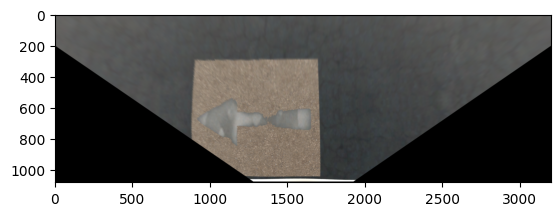

(<matplotlib.image.AxesImage at 0x25dba597790>, None)

In [6]:
front = cv2.imread('../data/fisheye/front_851.png')
front_pts1 = np.array([[150, 440], [1, 1080], [1280, 1080], [1280-150, 440]], dtype=np.float32)
front_pts2 = np.array([[100,30],[1,665],[1280,665],[1280-100,30]], dtype=np.float32)
frontU = undistort_fisheye(front, K, D, dim)
frontPC = perspective_crop(frontU, front_pts1)
frontPM = perspective_mapping(frontPC, front_pts2, (1280,1080))
front_final = enlarge_image(frontPM, 2.5)
plt.imshow(front_final), plt.show()


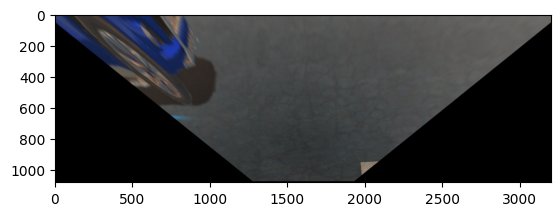

(<matplotlib.image.AxesImage at 0x25dba58bd90>, None)

In [7]:
left = cv2.imread('../data/fisheye/left_851.png')
left_pts1 = np.array([[200, 600], [1, 1080], [1280, 1080], [1280-200, 600]], dtype=np.float32)
left_pts2 = np.array([[25, 5], [5, 530], [1275, 530], [1280-25, 5]], dtype=np.float32)
leftU = undistort_fisheye(left, K, D, dim)
leftPC = perspective_crop(leftU, left_pts1)
leftPM = perspective_mapping(leftPC, left_pts2, (1280,1080))
left_final = enlarge_image(leftPM, 2.5)
plt.imshow(left_final), plt.show()


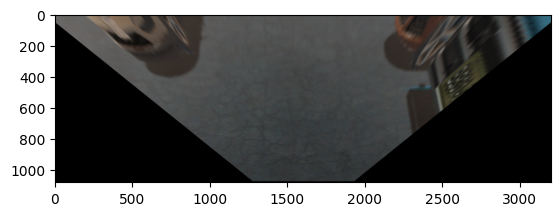

(<matplotlib.image.AxesImage at 0x25dbce71570>, None)

In [8]:
right = cv2.imread('../data/fisheye/right_851.png')
rightU = undistort_fisheye(right, K, D, dim)
right_pts1 = np.array([[200, 600], [1, 1080], [1280, 1080], [1280-200, 600]], dtype=np.float32)
right_pts2 = np.array([[25, 5], [5, 530], [1275, 530], [1280-25, 5]], dtype=np.float32)
rightPC = perspective_crop(rightU, right_pts1)
rightPM = perspective_mapping(rightPC, right_pts2, (1280,1080))
right_final = enlarge_image(rightPM, 2.5)
plt.imshow(right_final), plt.show()


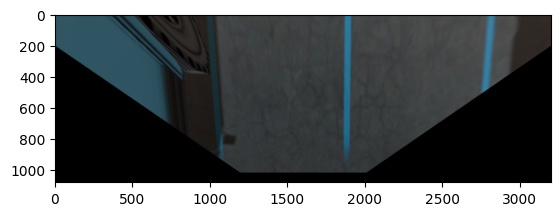

(<matplotlib.image.AxesImage at 0x25dbb5f88e0>, None)

In [9]:
rear = cv2.imread('../data/fisheye/rear_851.png')
rearU = undistort_fisheye( rear, K, D, dim)
rear_pts1 = np.array([[150, 600], [1, 1080], [1280, 1080], [1280-150, 600]], dtype=np.float32)
rear_pts2 = np.array([[100,30],[1,665],[1280,665],[1280-100,30]], dtype=np.float32)
rearPC = perspective_crop(rearU, rear_pts1)
rearPM = perspective_mapping(rearPC, rear_pts2, (1280,1080))
rear_final = enlarge_image(rearPM, 2.5)
plt.imshow(rear_final), plt.show()
